In [12]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import math

#Apod import
from scipy.signal import hamming
from scipy.signal import blackman
from scipy.signal import hann
from scipy.signal import kaiser

pi = np.pi

(140,)
2048
(140,)
2048
(140,)
2048
(140,)
2048
(140,)
2048
(140,)
2048
[-2.0754766089028673, -1.0377383044514337, -1.0377383044514337, -2.0754766089028673, 0.0, 0.0]


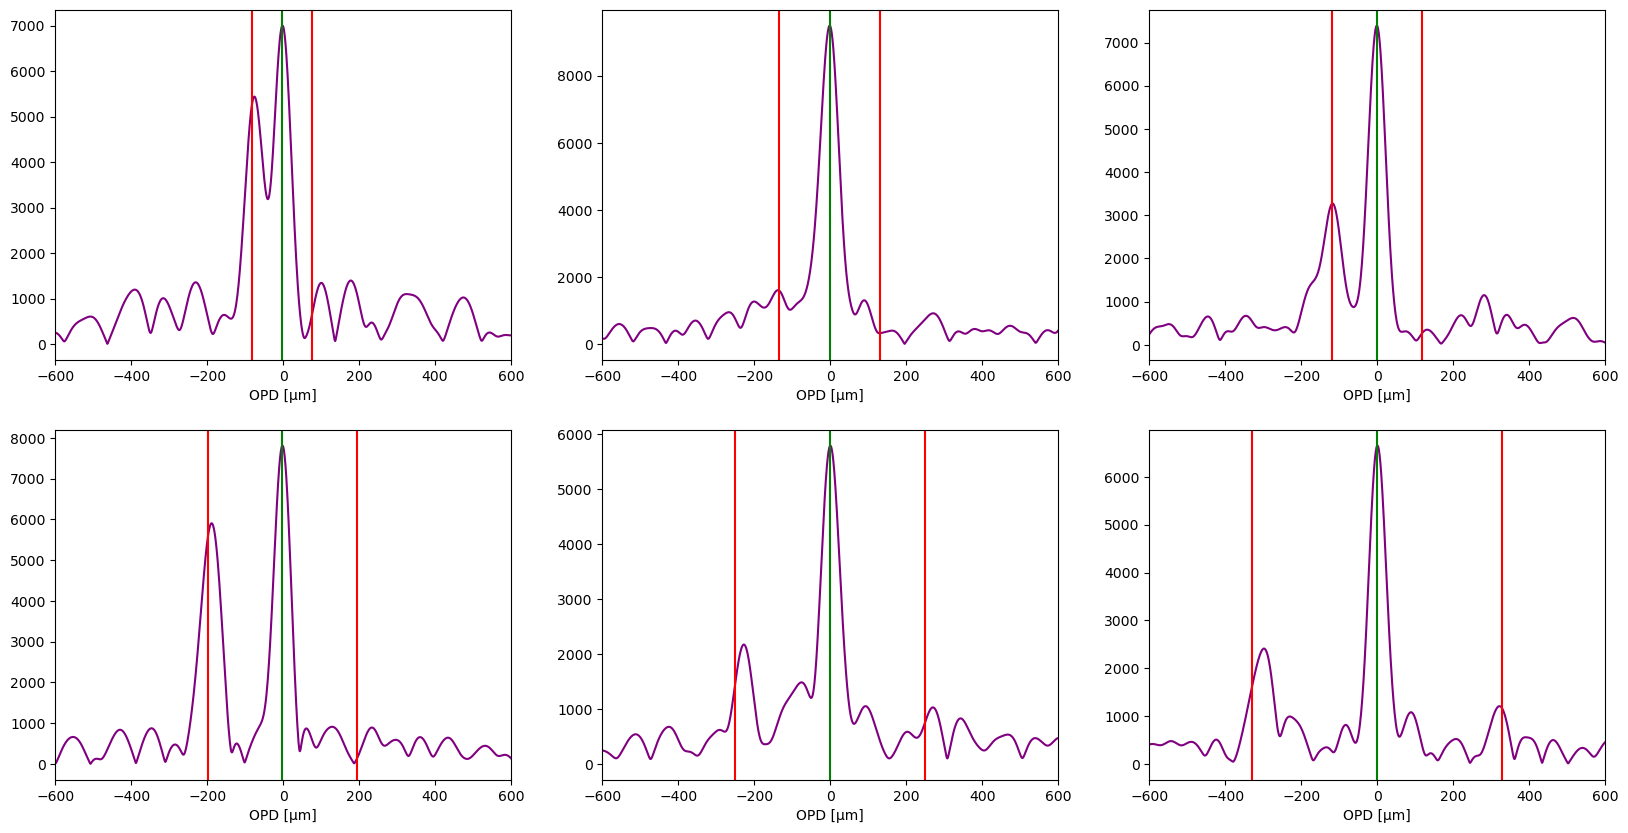

In [41]:

#lam = np.linspace(3.0, 4.5, 10001, endpoint=True)*1e-6

# #HR8799e
# offset_RA = -223.8
# offset_Dec = 332.1
# R = 0.0006973200286560031 
# contrast = 0.00015306216294306115 
# path = '/store/projects/MATISSE/jscigliuto/HR8799e_phase_corrected/corrected_data/2023-10-31T005004_OB2_exp13_frame5_planet.fits'

#Beta Pic b 
offset_RA = 281.6
offset_Dec = 452.8
R = 0.0017664150216057275
contrast = 0.0007914035074073295
path = '/store/projects/MATISSE/jscigliuto/betapicb_frames_corrected/2022-11-09T053024_OB2_exp3_frame5_planet_bin.fits'

def mas2rad(x):
    radx = x * (pi/180) * (1/3600000)
    return radx

offset_RA, offset_Dec = mas2rad(offset_RA), mas2rad(offset_Dec)

def det_OPD(offset_RA, offset_Dec, path, contrast, plot = True):
    
    hdul = fits.open(path)
    piston_lst = []

    #Baselines & coords 
    baselines = ['U1-U2', 'U1-U3', 'U1-U4', 'U2-U3', 'U2-U4', 'U3-U4']
    u = hdul['OI_VIS'].data['ucoord']
    v = hdul['OI_VIS'].data['vcoord']

    #Correlated flux    
    corrFlux_phi = hdul['OI_VIS'].data['VISPHI']
    corrFlux_amp = hdul['OI_VIS'].data['VISAMP']

    #Wavelength + mask in L-band
    lam = hdul['OI_WAVELENGTH'].data['EFF_WAVE']
    lam_mask = (lam >= 3.1e-6) & (lam <= 3.9e-6)
    lam = lam[lam_mask]


    if plot:
        fig, ax = plt.subplots(2, 3, figsize=(20,10))
        ax_flatten = ax.flatten()

    for k in range(len(u)):        
        
        #Correlated flux in L-band
        corrFlux_comp = corrFlux_amp[:,lam_mask] * np.exp(1j*corrFlux_phi[:,lam_mask]*pi/180)

        #Linear interpolation in wavenumber sigma
        sigma = 1.0/lam
        sigma = sigma[::-1]
        step = np.min(np.abs(np.diff(sigma)))
        sigma_lin = np.arange(min(sigma), max(sigma), step)

        #Interpolation of correlated flux 
        f = interpolate.interp1d(sigma, corrFlux_comp.real[k])
        corrFlux_real_interp = f(sigma_lin)
        f = interpolate.interp1d(sigma, corrFlux_comp.imag[k])
        corrFlux_imag_interp = f(sigma_lin)

        corrFlux_comp = corrFlux_real_interp + 1j * corrFlux_imag_interp
        print(corrFlux_comp.shape)
        
        #Apodisation
        #corrFlux_comp -= np.mean(corrFlux_comp) 
        
            #Cosinus
        # sigma_max = 1.0 / np.min(lam)
        # sigma_min = 1.0 / np.max(lam)
        # apod = 0.5*np.cos(2 * np.pi * (sigma_lin - sigma_min) / (sigma_max - sigma_min) + pi)+0.5
        # corrFlux_comp -= np.mean(corrFlux_comp)
        # corrFlux_comp *= apod
        # print(corrFlux_comp.shape)

            #Hamming
        # corrFlux_comp *= hamming(corrFlux_comp.size)
            #Hanning
        # corrFlux_comp *= np.hanning(corrFlux_comp.size)
            #Blackman
        # corrFlux_comp *= blackman(corrFlux_comp.size)
            #Kaiser
        # N = corrFlux_comp.size
        # beta = 20                    # Kaiser window parameter
        # apod = np.kaiser(N, beta)
        # corrFlux_comp *= apod


        #plt.plot(sigma_lin, apod, 'blue')
        #plt.plot(sigma_lin, corrFlux_comp, 'red')
        #plt.plot(sigma_lin, corrFlux_comp/apod, 'green')
        #plt.show()
        
        # Zero-padding
        log_base_2 = int(math.log2(corrFlux_comp.size)) 
        new_size = 2**(log_base_2+4)
        print(new_size)
        corrFlux_comp = np.pad(corrFlux_comp, (new_size - corrFlux_comp.size)//2, mode='constant', constant_values=0)

        #plt.plot(corrFlux_comp)
        #plt.show()

        #TF
        ft_phi = np.fft.fftshift(np.fft.fft(corrFlux_comp))
        OPD = np.fft.fftshift(np.fft.fftfreq(new_size, step)) * 1e6 

        #OPD determination
        piston = OPD[np.argmax(np.abs(ft_phi))] 
        piston_lst.append(piston)

        #wavelength mask's TF
        sinc = np.abs(ft_phi[np.argmax(np.abs(ft_phi))]) * np.sinc((np.max(lam) - np.min(lam))*(OPD-piston)*1e6/pi)

        if plot:
            ax_flatten[k].plot(OPD, np.sqrt(ft_phi.real**2 + ft_phi.imag**2), 'purple')
            ax_flatten[k].set_xlabel('OPD [µm]')
            #ax_flatten[k].axvline((offset_RA*u[k]+offset_Dec*v[k])*1e6, color='red')
            ax_flatten[k].axvline(piston, color='green')
            ax_flatten[k].axvline(piston+(offset_RA*u[k]+offset_Dec*v[k])*1e6, color='red')
            ax_flatten[k].axvline(piston-(offset_RA*u[k]+offset_Dec*v[k])*1e6, color='red')
            #ax_flatten[k].plot(OPD, sinc, 'orange')
            #ax_flatten[k].set_yscale('log')
            ax_flatten[k].set_xlim(-600, 600)

    return piston_lst

piston = det_OPD(offset_RA, offset_Dec, path, contrast, plot = True)
print(piston)


[53.96397598398938,
 -26.98198799199469,
 -8.993995997331563,
 53.96397598398938,
 -26.98198799199469,
 35.97598398932625]

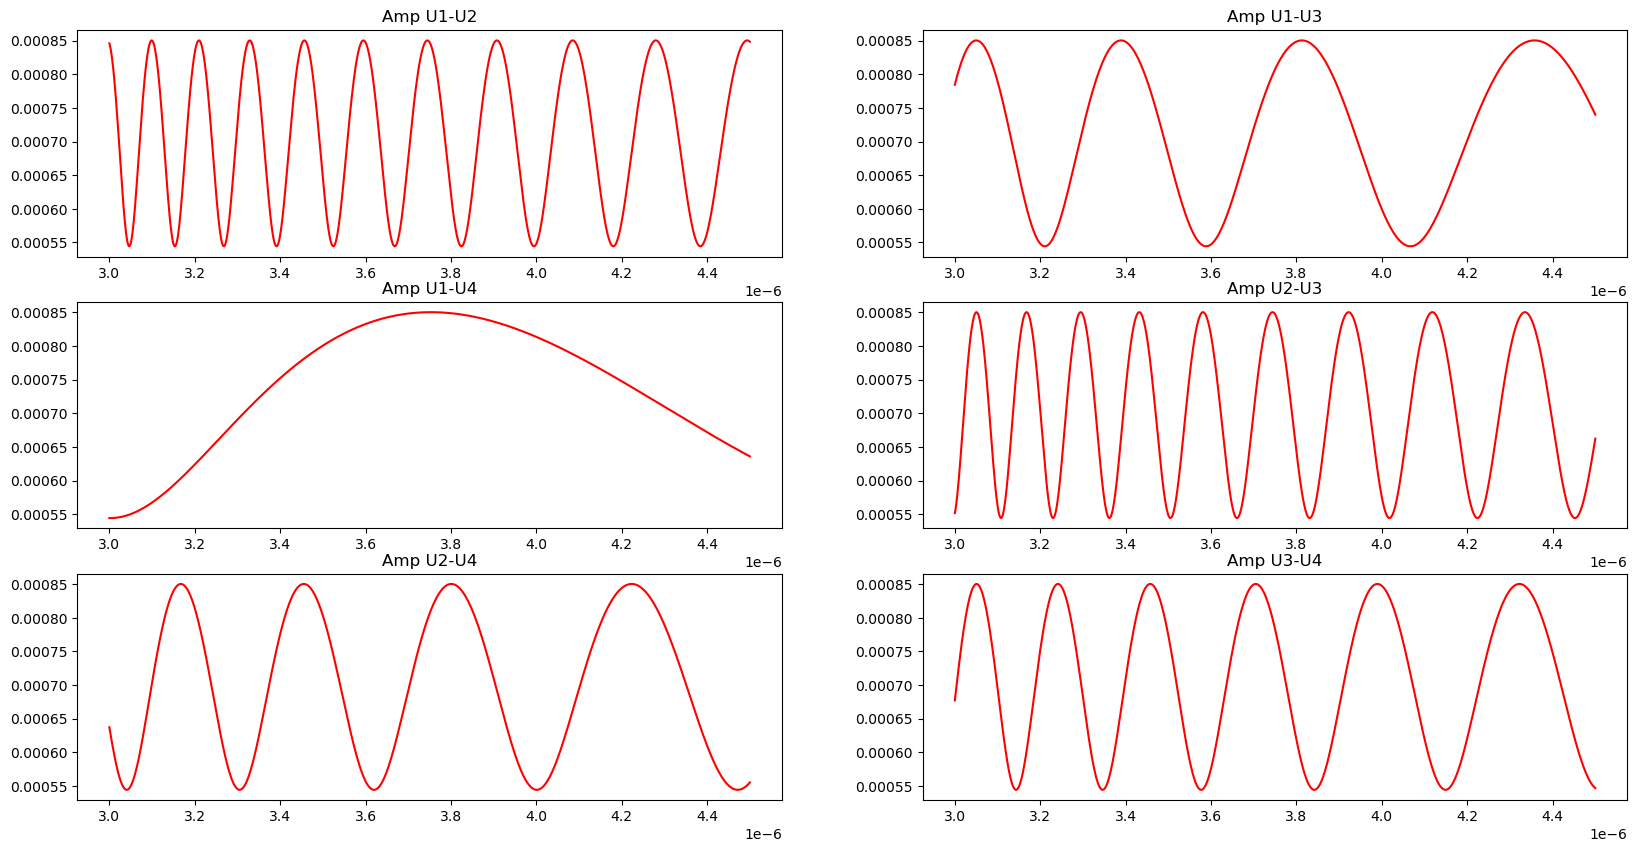

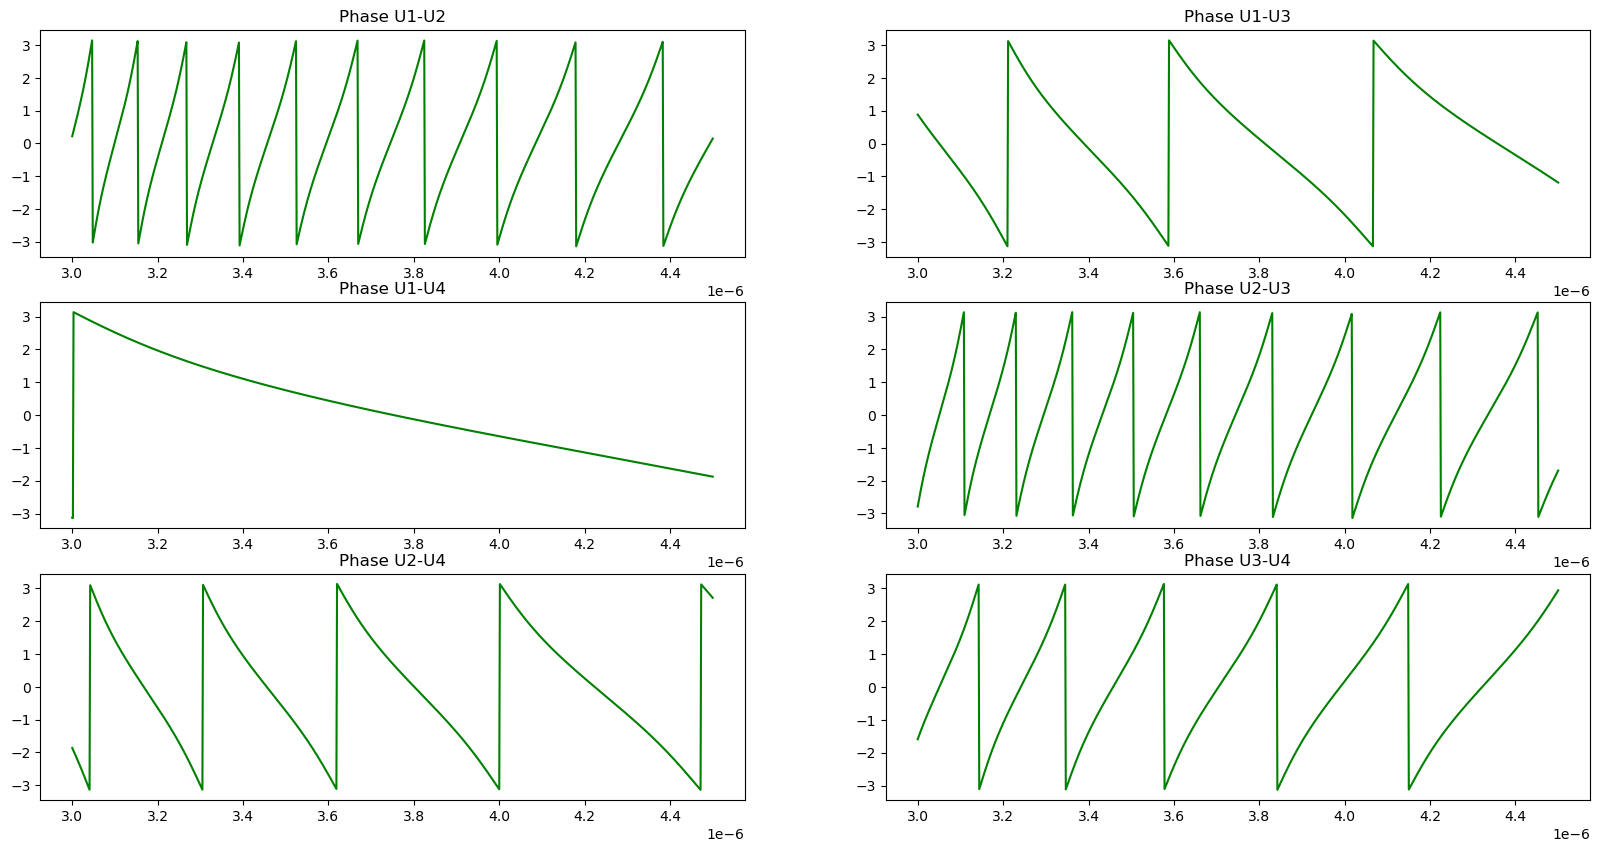

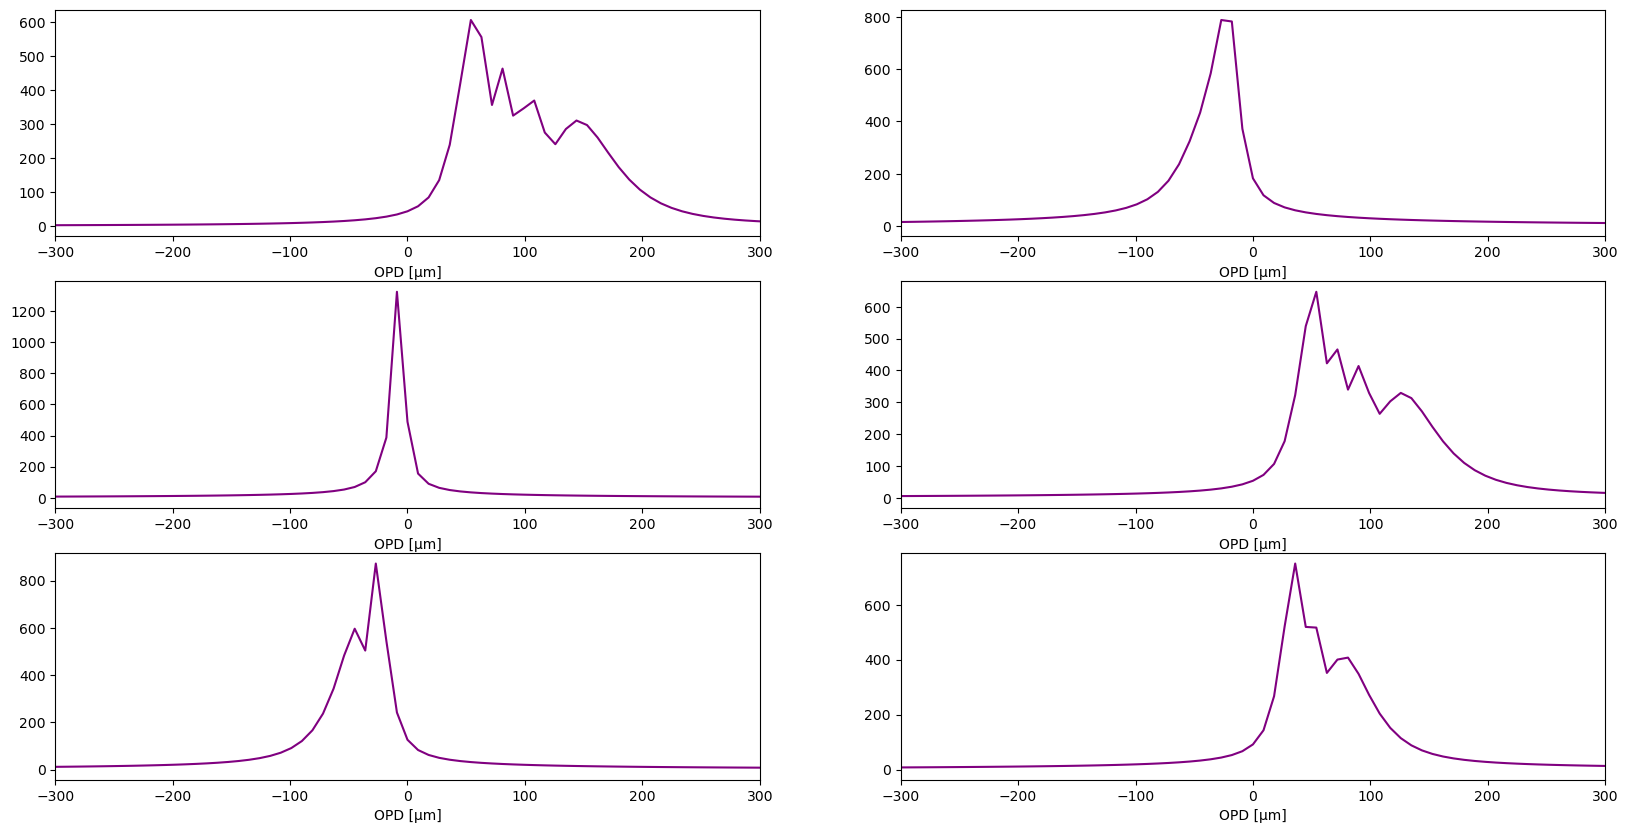

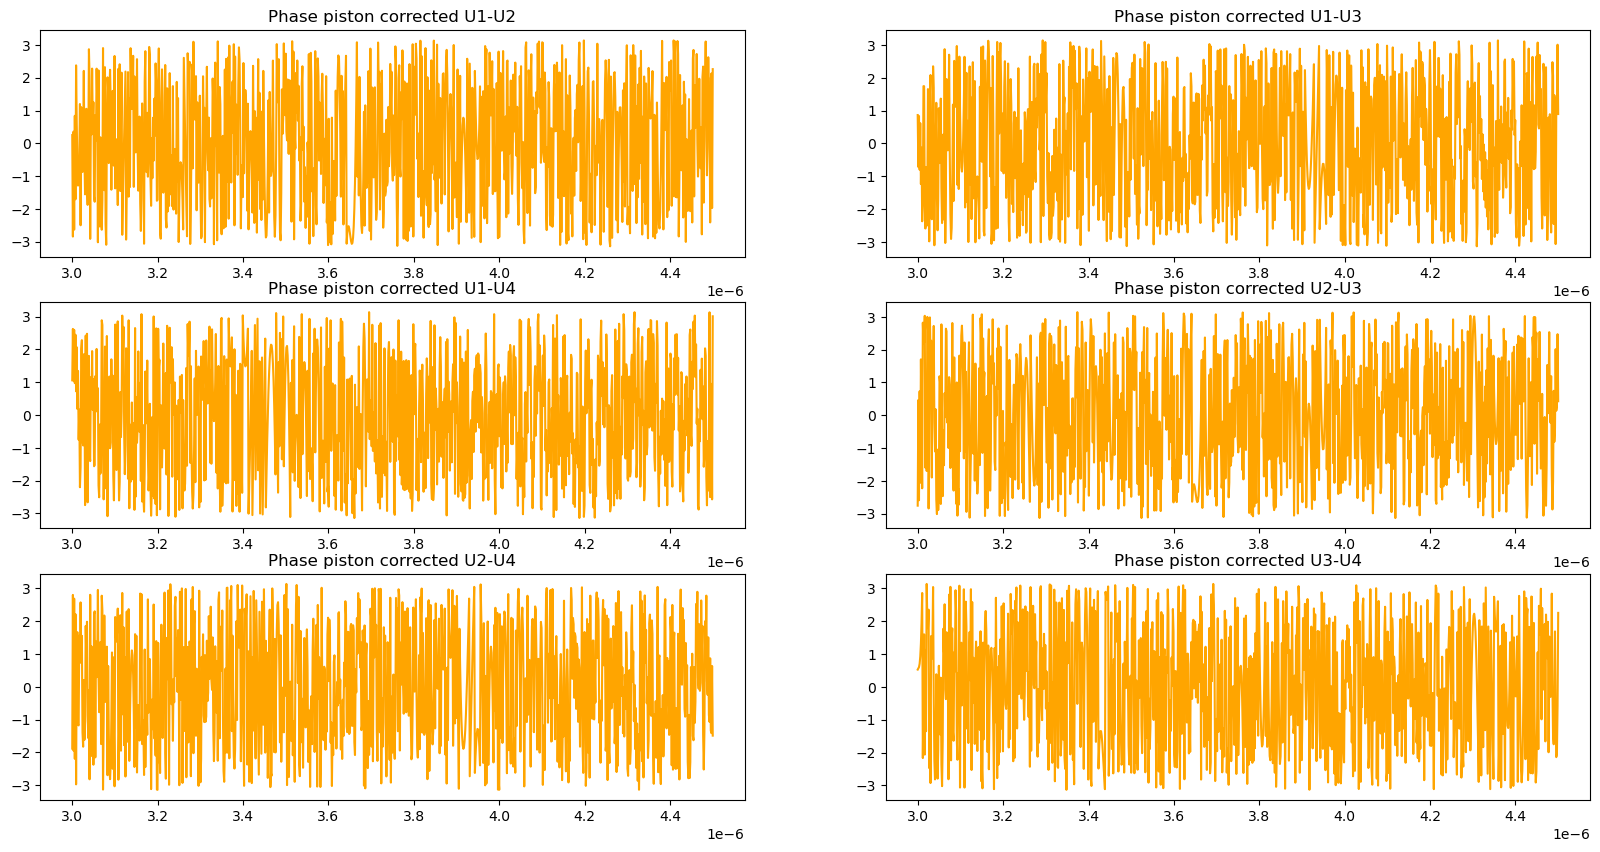

In [22]:
#HR8799e
offset_RA = -223.8
offset_Dec = 332.1
R = 0.0006973200286560031 
contrast = 0.00015306216294306115 
path = '/store/projects/MATISSE/jscigliuto/HR8799e_phase_corrected/corrected_data/2023-10-31T010342_OB2_exp22_frame4_planet.fits'

offset_RA, offset_Dec = mas2rad(offset_RA), mas2rad(offset_Dec)

def det_OPD_simu(offset_RA, offset_Dec, path, contrast, plot = True):
    
    piston_lst = []
    hdul = fits.open(path)

    #Baselines & coords
    baselines = ['U1-U2', 'U1-U3', 'U1-U4', 'U2-U3', 'U2-U4', 'U3-U4']
    u = hdul['OI_VIS'].data['ucoord']
    v = hdul['OI_VIS'].data['vcoord']

    #Wavelength
    lam = np.linspace(3, 4.5, 1000, endpoint=True) * 1e-6

    if plot:
        fig, ax = plt.subplots(3, 2, figsize=(20,10))
        ax_flatten = ax.flatten()
            
        fig, ax1 = plt.subplots(3, 2, figsize=(20,10))
        ax1_flatten = ax1.flatten()

        fig, ax2 = plt.subplots(3, 2, figsize=(20,10))
        ax2_flatten = ax2.flatten()

        fig, ax3 = plt.subplots(3, 2, figsize=(20,10))
        ax3_flatten = ax3.flatten()

    for k in range(len(u)):   

        #Correlated flux     
        corrFlux = contrast + R*np.exp(2j * pi * (offset_RA*u[k] + offset_Dec*v[k]) / lam)

        #Module & phase
        phi = np.angle(corrFlux)
        module = np.abs(corrFlux)

        #Correlated flux, module = 1 to remove the modulations on the oscillations
        corrFlux1 = np.exp(2j * pi * (offset_RA*u[k] + offset_Dec*v[k]) / lam)

        #Linear interpolation in wavenumber sigma
        sigma = 1.0/lam
        sigma = sigma[::-1]
        step = np.min(np.abs(np.diff(sigma)))
        sigma_lin = np.arange(min(sigma), max(sigma), step)

        #Interpolation of correlated flux
        f = interpolate.interp1d(sigma, corrFlux1.real)
        corrFlux_real_interp = f(sigma_lin)
        f = interpolate.interp1d(sigma, corrFlux1.imag)
        corrFlux_imag_interp = f(sigma_lin)

        corrFlux_interp = corrFlux_real_interp + 1j * corrFlux_imag_interp

        #TF
        ft_phi = np.fft.fftshift(np.fft.fft(corrFlux_interp))
        OPD = np.fft.fftshift(np.fft.fftfreq(sigma_lin.size, step)) * 1e6

        #OPD determination
        piston = OPD[np.argmax(np.abs(ft_phi))] 
        piston_lst.append(piston)

        #OPD correction
        phi_piston_corrected = np.exp(1j * phi) * np.exp(-2j * pi * piston / lam )
        
        if plot:
            ax_flatten[k].plot(lam, module, 'red')
            ax_flatten[k].set_title(f'Amp {baselines[k]}')

            ax1_flatten[k].plot(lam, phi, 'green')
            ax1_flatten[k].set_title(f'Phase {baselines[k]}')
            
            ax2_flatten[k].plot(OPD, np.abs(ft_phi), 'purple')
            ax2_flatten[k].set_xlabel('OPD [µm]')
            ax2_flatten[k].set_xlim(-300, 300)

            ax3_flatten[k].plot(lam, np.angle(phi_piston_corrected), 'orange')
            ax3_flatten[k].set_title(f'Phase piston corrected {baselines[k]}')
    
    return piston_lst

det_OPD_simu(offset_RA, offset_Dec, path, contrast, plot = True)


In [ ]:
#lam = np.linspace(3.0, 4.5, 10001, endpoint=True)*1e-6

#HR8799e
offset_RA = -223.8
offset_Dec = 332.1
R = 0.0006973200286560031 
contrast = 0.00015306216294306115 
path = '/store/projects/MATISSE/jscigliuto/HR8799e_phase_corrected/corrected_data/2023-10-31T005004_OB2_exp13_frame5_planet.fits'

# #Beta Pic b 
# offset_RA = 281.6
# offset_Dec = 452.8
# R = 0.0017664150216057275
# contrast = 0.0007914035074073295
# path = '/store/projects/MATISSE/jscigliuto/2022-11-09T054520_OB2_exp12_frame4_planet.fits'

def mas2rad(x):
    radx = x * (pi/180) * (1/3600000)
    return radx

offset_RA, offset_Dec = mas2rad(offset_RA), mas2rad(offset_Dec)

def det_OPD(offset_RA, offset_Dec, path, contrast, plot = True):
    
    hdul = fits.open(path)
    piston_lst = []

    #Baselines & coords 
    baselines = ['U1-U2', 'U1-U3', 'U1-U4', 'U2-U3', 'U2-U4', 'U3-U4']
    u = hdul['OI_VIS'].data['ucoord']
    v = hdul['OI_VIS'].data['vcoord']

    #Correlated flux    
    corrFlux_phi = hdul['OI_VIS'].data['VISPHI']
    corrFlux_amp = hdul['OI_VIS'].data['VISAMP']

    #Wavelength + mask in L-band
    lam = hdul['OI_WAVELENGTH'].data['EFF_WAVE']
    lam_mask = (lam >= 3.1e-6) & (lam <= 3.9e-6)
    lam = lam[lam_mask]


    if plot:
        fig, ax = plt.subplots(2, 3, figsize=(20,10))
        ax_flatten = ax.flatten()

    for k in range(len(u)):        
        
        #Correlated flux in L-band
        corrFlux_comp = corrFlux_amp[:,lam_mask] * np.exp(1j*corrFlux_phi[:,lam_mask]*pi/180)

        #Linear interpolation in wavenumber sigma
        sigma = 1.0/lam
        sigma = sigma[::-1]
        step = np.min(np.abs(np.diff(sigma)))
        sigma_lin = np.arange(min(sigma), max(sigma), step)

        #Interpolation of correlated flux 
        f = interpolate.interp1d(sigma, corrFlux_comp.real[k])
        corrFlux_real_interp = f(sigma_lin)
        f = interpolate.interp1d(sigma, corrFlux_comp.imag[k])
        corrFlux_imag_interp = f(sigma_lin)

        corrFlux_comp = corrFlux_real_interp + 1j * corrFlux_imag_interp
        print(corrFlux_comp.shape)

        #Apodisation
        sigma_max = 1.0 / np.min(lam)
        sigma_min = 1.0 / np.max(lam)
        apod = np.cos(2 * np.pi * (sigma_lin - sigma_min) / (sigma_max - sigma_min))
        corrFlux_comp *= apod
        print(corrFlux_comp.shape)
        
        # Zero-padding
        log_base_2 = int(math.log2(corrFlux_comp.size)) 
        new_size = 2**(log_base_2+4)
        print(new_size)
        corrFlux_comp = np.fft.fftshift(corrFlux_comp)
        corrFlux_comp = np.pad(corrFlux_comp, (new_size - corrFlux_comp.size)//2, mode='constant', constant_values=0)

        #TF
        ft_phi = np.fft.fftshift(np.fft.fft(corrFlux_comp))
        OPD = np.fft.fftshift(np.fft.fftfreq(new_size, step)) * 1e6 

        #OPD determination
        piston = OPD[np.argmax(np.abs(ft_phi))] 
        piston_lst.append(piston)

        #wavelength mask's TF
        sinc = np.abs(ft_phi[np.argmax(np.abs(ft_phi))]) * np.sinc((np.max(lam) - np.min(lam))*(OPD-piston)*1e6/pi)

        if plot:
            ax_flatten[k].plot(OPD, np.abs(ft_phi), 'purple')
            ax_flatten[k].set_xlabel('OPD [µm]')
            #ax_flatten[k].axvline((offset_RA*u[k]+offset_Dec*v[k])*1e6, color='red')
            ax_flatten[k].axvline(piston, color='green')
            ax_flatten[k].axvline(piston+(offset_RA*u[k]+offset_Dec*v[k])*1e6, color='red')
            ax_flatten[k].axvline(piston-(offset_RA*u[k]+offset_Dec*v[k])*1e6, color='red')
            #ax_flatten[k].plot(OPD, sinc, 'orange')
            #ax_flatten[k].set_yscale('log')
            ax_flatten[k].set_xlim(-400, 400)

    return piston_lst

piston = det_OPD(offset_RA, offset_Dec, path, contrast, plot = True)
print(piston)
